In [2]:
import numpy as np
import tensorflow as tf
import keras
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
import seaborn as sb

Using TensorFlow backend.


Pobranie danych:

In [3]:
import os,sys
file_path = os.path.join(os.path.realpath("."), "autos_utf8.csv")
file_path


'C:\\Users\\Admin\\Documents\\Python\\Projekt\\tpsi\\projektPSI\\autos_utf8.csv'

In [4]:
data = pd.read_csv(file_path)
data.head()
data = data[data["offerType"]=="Angebot"]
data = data[data["model"].isnull() == False]
data = data[data["notRepairedDamage"].isnull() == False]
data = data[data["model"] != "andere"]
data = data[data["price"] > np.percentile(data["price"],5)]
data = data[data["price"] < np.percentile(data["price"],95)]

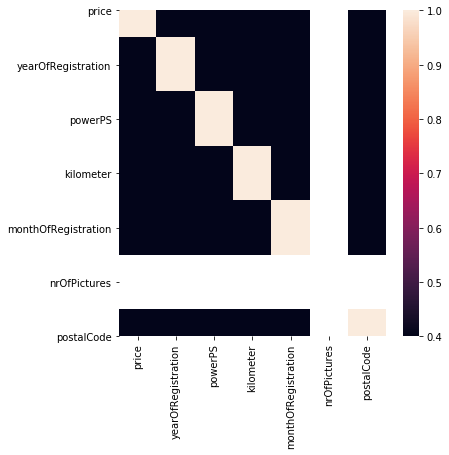

In [5]:
C_mat = data.corr()
fig = plt.figure(figsize = (6,6))
sb.heatmap(C_mat, vmax = 1, vmin=0.4)
plt.show()

In [6]:
mpm = data['model'].value_counts()[:50].sort_values(ascending=False)
data = data.loc[data['model'].isin(mpm.index)]
data = data[0:5000]
# print(mpm.index.array)
data['nrOfPictures'].value_counts()

0    5000
Name: nrOfPictures, dtype: int64

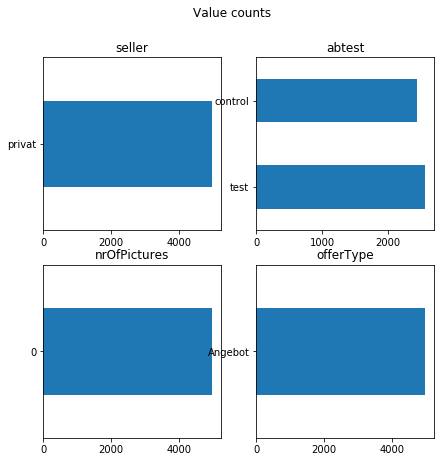

In [16]:
fig, ax = plt.subplots(2, 2)
fig.suptitle('Value counts')
cols = ['seller','abtest',"nrOfPictures","offerType"]
for i in range(0,4):
    data[cols[i]].value_counts().plot(kind='barh', ax=ax[int(i/2),int(i%2)], title=cols[i], figsize=(7,7))

In [8]:
y = data['price']
X = data.drop(['seller',"price",'abtest',"lastSeen","dateCreated","dateCrawled","name","nrOfPictures","offerType"], axis=1)

In [9]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)
    
ps_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["powerPS"])),
#         ("imputer", SimpleImputer(strategy="median", missing_values=0)),
])
num_pipeline = Pipeline([
        ("select_numeric", DataFrameSelector(["yearOfRegistration","kilometer","monthOfRegistration","postalCode"])),
        ("imputer", SimpleImputer(strategy="median")),
])
cat_pipeline = Pipeline([
        ("select_cat", DataFrameSelector(["vehicleType","notRepairedDamage", "fuelType", "gearbox","model"])),
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(dtype=np.int8, sparse=False, handle_unknown = 'ignore')),
    ])

preprocess_pipeline = FeatureUnion(transformer_list=[
        ("ps_pipeline", ps_pipeline),
        ("num_pipeline", num_pipeline),
        ("cat_pipeline", cat_pipeline),
    ])


processedX = preprocess_pipeline.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(processedX, y, test_size=0.2, random_state=42)



In [10]:
X_train[0]
# X_train.size

array([8.2000e+01, 2.0070e+03, 9.0000e+04, 3.0000e+00, 8.0999e+04,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00,
       0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00])

In [11]:
from sklearn.preprocessing import MinMaxScaler, Normalizer, StandardScaler
scaler = MinMaxScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train[0]

array([0.13598673, 0.78846154, 0.5862069 , 0.25      , 0.80815311,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 0.        , 0.        , 1.        , 0.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        ])

In [12]:
from sklearn.model_selection import GridSearchCV
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import VotingRegressor
from keras.layers import BatchNormalization
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import EarlyStopping
from sklearn.svm import LinearSVR
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV
from keras.layers.advanced_activations import PReLU
from keras.regularizers import l1,l2
from keras.wrappers.scikit_learn import KerasRegressor
from keras import activations
from xgboost import XGBRegressor
seed=123
kfold = model_selection.KFold(n_splits=5, random_state=seed)
models = []

E:\Anaconda\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


In [13]:
grid_1 = GridSearchCV(estimator=make_pipeline(PolynomialFeatures(degree=2), ElasticNet(alpha=1, tol=0.001)),
                      param_grid={'polynomialfeatures__degree': [2],
                      'elasticnet__alpha': [0.01,.001]},
                      scoring='r2',
                      cv=kfold,
                     n_jobs=-1)

grid_1.fit(X_train, y_train)
print(grid_1.best_params_)
print(grid_1.best_score_)

{'elasticnet__alpha': 0.001, 'polynomialfeatures__degree': 2}
0.7702435444306737


E:\Anaconda\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8269212230.928406, tolerance: 82699459.98809612
  positive)


In [14]:
grid_2 = GridSearchCV(estimator=make_pipeline(PolynomialFeatures(degree=2), linear_model.LinearRegression()),
                      param_grid={'polynomialfeatures__degree': [1]},
                      scoring='r2',
                      cv=kfold,
                     n_jobs=-1)

grid_2.fit(X_train, y_train)
print(grid_2.best_params_)
print(grid_2.best_score_)

{'polynomialfeatures__degree': 1}
-1.4284184246983815e+21


In [15]:
grid_3 = GridSearchCV(estimator=make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=1, tol=0.1)),
                      param_grid={'polynomialfeatures__degree': [2,3],
                      'ridge__alpha': [0.1,1]},
                      scoring='r2',
                      cv=kfold,
                     n_jobs=-1)
grid_3.fit(X_train, y_train)
print(grid_3.best_params_)
print(grid_3.best_score_)

{'polynomialfeatures__degree': 2, 'ridge__alpha': 1}
0.7735758448893387


In [16]:
grid_4 = GridSearchCV(estimator=make_pipeline(PolynomialFeatures(degree=2), Lasso(alpha=1, tol=0.1)),
                      param_grid={'polynomialfeatures__degree': [2,4],
                      'lasso__alpha': [0.1,1]},
                      scoring='r2',
                      cv=kfold,
                     n_jobs=-1)

grid_4.fit(X_train, y_train)
print(grid_4.best_params_)
print(grid_4.best_score_)

{'lasso__alpha': 1, 'polynomialfeatures__degree': 2}
0.7595721247400038


In [17]:
grid_5 = GridSearchCV(estimator=make_pipeline(LinearSVR(C=1.0)),
                      param_grid={
                      'linearsvr__C': [1,10,100,1000,10000]},
                      scoring='r2',
                      cv=kfold,
                     n_jobs=-1)
grid_5.fit(X_train, y_train)
print(grid_5.best_params_)
print(grid_5.best_score_)

{'linearsvr__C': 10000}
0.6561611765692298


E:\Anaconda\lib\site-packages\sklearn\svm\_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [18]:
parameters = {
    'max_depth': [2,5,10],
    'n_estimators': [50,100,150],
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_6 = GridSearchCV(estimator=XGBRegressor(nthread=8),
                      param_grid=parameters,
                      scoring='r2',
                      cv=kfold,
                     n_jobs=-1)
grid_6.fit(X_train, y_train)
print(grid_6.best_params_)
print(grid_6.best_score_)

[11:57:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 150}
0.8502836667242551


In [19]:
VR = VotingRegressor([('r1',grid_3.best_estimator_), ('r2',grid_6.best_estimator_)])
vrmodel = VR.fit(X_train, y_train)

[11:57:47] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [56]:
# X_train_train, X_valid, y_train_train, y_valid = train_test_split(X_train, y_train, random_state=42)
early_stopping = EarlyStopping(monitor='loss', patience=3, mode='min', verbose=1)

nnmodel = keras.models.Sequential()
nnmodel.add(Dense(1000, activation="relu", input_shape=X_train.shape[1:]))
nnmodel.add(Dense(100,activation="relu"))
nnmodel.add(Dense(50,activation="relu"))
nnmodel.add(Dense(1))
nnmodel.summary()
nnmodel.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
nnh = nnmodel.fit(X_train, y_train, epochs=1000, batch_size=128, validation_split=0.2, callbacks=[early_stopping])


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 1000)              73000     
_________________________________________________________________
dense_22 (Dense)             (None, 100)               100100    
_________________________________________________________________
dense_23 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 51        
Total params: 178,201
Trainable params: 178,201
Non-trainable params: 0
_________________________________________________________________
Train on 3195 samples, validate on 799 samples
Epoch 1/1000
3195/3195 [==============================] - 0s 106us/step - loss: 45705011.6870 - mean_squared_error: 45705008.0000 - val_loss: 45057104.0050 - val_mean_squared_error: 45057104.0000
Epo

Epoch 81/1000
3195/3195 [==============================] - 0s 34us/step - loss: 4172303.5028 - mean_squared_error: 4172303.2500 - val_loss: 5662385.7772 - val_mean_squared_error: 5662386.0000
Epoch 00081: early stopping


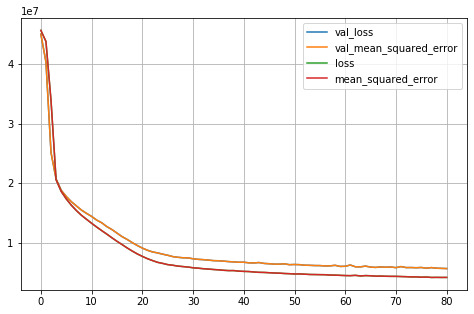

In [57]:
pd.DataFrame(nnh.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [21]:
def build_model(n_h1=1,n_h2=1, n_neurons=1000, l1_penalty = 0.01, dropout_rate = 0,  learning_rate=3e-3, input_shape =X_train.shape[1:], dropout = False, bn = False):
    model = keras.models.Sequential() 
    for layer in range(n_h1):
        if layer == 0:
                model.add(Dense(int(n_neurons/n_h1), input_shape=input_shape, kernel_regularizer = l1(l1_penalty)))
        else:
            model.add(Dense(int(n_neurons/n_h1), kernel_regularizer = l1(l1_penalty)))
        if bn:
            model.add(BatchNormalization())
        model.add(Activation(activations.relu))  
        if dropout:
            model.add(Dropout(p = dropout_rate))
    for layer in range(n_h2):
        model.add(Dense(int(n_neurons/10/n_h2), kernel_regularizer = l1(l1_penalty)))
        if bn:
            model.add(BatchNormalization())
        model.add(Activation(activations.relu))  
        if dropout:
            model.add(Dropout(p = dropout_rate))        
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.Adam(lr=learning_rate)
    model.compile(loss="mean_squared_error", optimizer=optimizer, metrics=["mean_squared_error"])
    return model

In [22]:
early_stopping = EarlyStopping(monitor='loss', patience=3, mode='min', verbose=1)
callbacks = [early_stopping]

nn2 = KerasRegressor(build_fn = build_model, epochs=20, batch_size=128, verbose=0)

param_grid = {
    "n_h1": [1,2,3],
    "n_h2": [1,2,3,4,5],
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],  
    'l1_penalty': [0, 0.3],
    'dropout': [True,False],
    'bn': [True,False]
}
nn2_model = RandomizedSearchCV(estimator=nn2, cv=kfold, param_distributions=param_grid, verbose=1, scoring='r2', n_iter=10, n_jobs=-1)
nn2_model.fit(X_train, y_train)
nn2_model.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
E:\Anaconda\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.9min finished


{'n_h2': 4,
 'n_h1': 3,
 'l1_penalty': 0.3,
 'dropout_rate': 0.4,
 'dropout': False,
 'bn': False}

In [23]:
early_stopping = EarlyStopping(monitor='loss', patience=6, mode='min', verbose=1)
nn3= build_model(**nn2_model.best_params_)
nn3.compile(loss= "mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
nn3h = nn3.fit(X_train, y_train, epochs=200, batch_size=128, validation_split=0.2, callbacks=[early_stopping])

Train on 3195 samples, validate on 799 samples
Epoch 1/200
3195/3195 [==============================] - 1s 193us/step - loss: 45587339.1925 - mean_squared_error: 45583728.0000 - val_loss: 44112019.2441 - val_mean_squared_error: 44108588.0000
Epoch 2/200
3195/3195 [==============================] - 0s 54us/step - loss: 33144396.7274 - mean_squared_error: 33140944.0000 - val_loss: 24495477.5444 - val_mean_squared_error: 24491920.0000
Epoch 3/200
3195/3195 [==============================] - 0s 55us/step - loss: 19822024.5966 - mean_squared_error: 19818650.0000 - val_loss: 18894118.7121 - val_mean_squared_error: 18890836.0000
Epoch 4/200
3195/3195 [==============================] - 0s 58us/step - loss: 16833730.9834 - mean_squared_error: 16830488.0000 - val_loss: 16966714.8974 - val_mean_squared_error: 16963476.0000
Epoch 5/200
3195/3195 [==============================] - 0s 55us/step - loss: 15118979.9850 - mean_squared_error: 15115704.0000 - val_loss: 15740249.5119 - val_mean_squared_err

Epoch 86/200
3195/3195 [==============================] - 0s 56us/step - loss: 2646728.8362 - mean_squared_error: 2641883.5000 - val_loss: 4595143.8523 - val_mean_squared_error: 4590296.5000
Epoch 87/200
3195/3195 [==============================] - 0s 54us/step - loss: 2594564.3975 - mean_squared_error: 2589713.2500 - val_loss: 4620184.5651 - val_mean_squared_error: 4615330.0000
Epoch 88/200
3195/3195 [==============================] - 0s 51us/step - loss: 2584872.0301 - mean_squared_error: 2580014.5000 - val_loss: 4577259.8508 - val_mean_squared_error: 4572402.0000
Epoch 89/200
3195/3195 [==============================] - 0s 54us/step - loss: 2558640.5630 - mean_squared_error: 2553776.0000 - val_loss: 4721971.2922 - val_mean_squared_error: 4717107.5000
Epoch 90/200
3195/3195 [==============================] - 0s 53us/step - loss: 2506006.1811 - mean_squared_error: 2501132.7500 - val_loss: 4717254.8364 - val_mean_squared_error: 4712383.0000
Epoch 91/200
3195/3195 [=====================

In [60]:
print(nn3.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 333)               24309     
_________________________________________________________________
activation_8 (Activation)    (None, 333)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 333)               111222    
_________________________________________________________________
activation_9 (Activation)    (None, 333)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 333)               111222    
_________________________________________________________________
activation_10 (Activation)   (None, 333)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 25)               

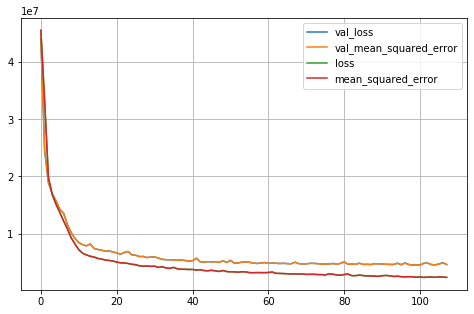

In [24]:
pd.DataFrame(nn3h.history).plot(figsize=(8, 5))
plt.grid(True)
plt.show()

In [25]:
models=[]
models.append(('ElasticNet', grid_1.best_estimator_))
models.append(('Linear Regression', grid_2.best_estimator_))
models.append(('Ridge', grid_3.best_estimator_))
models.append(('Lasso', grid_4.best_estimator_))
models.append(('SVR linear', grid_5.best_estimator_))
models.append(('XGBRegressor', grid_6.best_estimator_))
models.append(('MLP1', nnmodel))
models.append(('MLP2', nn3))
models.append(('Voting', vrmodel))


In [26]:
r2 = []
explained_variance_score = []
median_absolute_error = []
mean_squared_error = []
mean_absolute_error = []
for name, model in models:
    print(name)
    print("R^2: {}".format(metrics.r2_score(y_test, model.predict(X_test)) ))
    print("Explained variance score: {}".format( metrics.explained_variance_score(y_test, model.predict(X_test)) ))
    print("Median absolute error: {}".format( metrics.median_absolute_error(y_test, model.predict(X_test)) ))
    print("Mean squared error: {}".format( metrics.mean_squared_error(y_test, model.predict(X_test)) ))
    print("Mean absolute errors: {}".format(metrics.mean_absolute_error(y_test, model.predict(X_test)) ))
    r2.append(metrics.r2_score(y_test, model.predict(X_test)))
    explained_variance_score.append(metrics.explained_variance_score(y_test, model.predict(X_test)))
    median_absolute_error.append( metrics.median_absolute_error(y_test, model.predict(X_test)))
    mean_squared_error.append(metrics.mean_squared_error(y_test, model.predict(X_test)))
    mean_absolute_error.append(metrics.mean_absolute_error(y_test, model.predict(X_test)))

d = {'r2': r2, 
     'explained_variance_score': explained_variance_score, 
     'median_absolute_error': median_absolute_error,
     'mean_squared_error' : mean_squared_error,
     'mean_absolute_error' : mean_absolute_error,
    }
df = pd.DataFrame(data=d)

df.insert(loc=0, column='Method', value=np.reshape(models,(int(len(models)),2))[:,0])
df

ElasticNet
R^2: 0.7596842474615544
Explained variance score: 0.7607408947134656
Median absolute error: 1036.6340972460548
Mean squared error: 5129078.913566269
Mean absolute errors: 1524.0996688500597
Linear Regression
R^2: 0.6660183083181606
Explained variance score: 0.6678025326192283
Median absolute error: 1386.0
Mean squared error: 7128198.772772773
Mean absolute errors: 1936.7447447447448
Ridge
R^2: 0.7630685775798867
Explained variance score: 0.7640144505883776
Median absolute error: 1023.1174956231534
Mean squared error: 5056846.876909793
Mean absolute errors: 1499.685317937649
Lasso
R^2: 0.7499532870502421
Explained variance score: 0.750589774174906
Median absolute error: 965.742034861938
Mean squared error: 5336767.603663375
Mean absolute errors: 1515.378643761698
SVR linear
R^2: 0.6356681052945077
Explained variance score: 0.6475609051202433
Median absolute error: 1197.3922200182487
Mean squared error: 7775965.657409972
Mean absolute errors: 1914.1835660112856
XGBRegressor
R^

,Method,r2,explained_variance_score,median_absolute_error,mean_squared_error,mean_absolute_error
0,ElasticNet,0.759684,0.760741,1036.634097,5.129079e+06,1524.099669
1,Linear Regression,0.666018,0.667803,1386.000000,7.128199e+06,1936.744745
2,Ridge,0.763069,0.764014,1023.117496,5.056847e+06,1499.685318
3,Lasso,0.749953,0.750590,965.742035,5.336768e+06,1515.378644
4,SVR linear,0.635668,0.647561,1197.392220,7.775966e+06,1914.183566
5,XGBRegressor,0.838226,0.838318,740.980225,3.452757e+06,1198.014423
6,MLP1,0.757456,0.760086,918.283691,5.176635e+06,1481.463258
7,MLP2,0.768364,0.768782,882.736328,4.943816e+06,1431.910804
8,Voting,0.833439,0.833846,780.478846,3.554925e+06,1218.312733
